# Distance from Initialization in Two Layers

## Init

In [1]:
#Autocomplete
%config Completer.use_jedi = False

In [2]:
%matplotlib inline
%time

import numpy as np
import matplotlib.pyplot as plt
import os

Wall time: 0 ns


In [3]:
os.environ['KERAS_BACKEND'] = "tensorflow"

import keras
from keras import models, layers, activations, initializers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.initializers import glorot_normal, RandomNormal
from keras.callbacks import EarlyStopping
from keras.engine import base_layer
from keras.utils import control_flow_util
import tensorflow as tf
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

In [4]:
# adding project's file
import metric as M
from visualization import visualize

## I/O

In [5]:
# Dump
r"""
import pickle

with open(r'C:\Users\elad\work\python_output\random_sketch.pkl', 'wb') as f:
    pickle.dump(result, f)
"""

# Load
r"""
import pickle

with open(r'C:\Users\elad\work\python_output\random_sketch.pkl', 'rb') as f:
    result = pickle.load(f)
"""

"\nimport pickle\n\nwith open(r'C:\\Users\\elad\\work\\python_output\\random_sketch.pkl', 'rb') as f:\n    result = pickle.load(f)\n"

## Two-Layers Network that Remembers Distance

In [6]:
DISTANCE_METRIC = 'distance_from_init'
GRADIENT_METRIC = 'loss_gradient_norm'

In [7]:
def get_generalization(history, metric='loss'):
    return np.array(history.history['val_' + metric]) - np.array(history.history[metric])

In [8]:
# This metric will be called twice -
# The first time with real y_true, y_pred and there is nothing to get from it
# The second time, the real value will be in y_true and y_pred will be Zero
def changableMetric (name):
    def fn (y_true, y_pred):
        if tf.size(y_pred) == 1:
            # we multiply by 2 as the metric gets the average of all return values,
            # in our case, the average of 0 and the real value
            return 2 * y_true
        return tf.constant(0, dtype=tf.float32)
    
    fn.__name__ = name
    return fn

In [9]:
class SimpleNN(Model):
    def __init__(self, input_dim,
                 hidden_layers=None,
                 dist_from_init=None,
                 learning_rate=0.1,
                 last_layer_activation='sigmoid',
                 dropout_rate = None,
                 seed=0,
                 **kwargs):
        super(SimpleNN, self).__init__(**kwargs)
        
        self.distance_from_init = dist_from_init
        self.dropout_rate = dropout_rate
        if dist_from_init is not None:
            self.distance_from_init = tf.constant(dist_from_init, dtype=tf.float32)
        
        if hidden_layers is None:
            hidden_layers = input_dim
            
        self.seq = Sequential()
        self.d1 = Dense(hidden_layers, input_dim=input_dim, activation='relu', use_bias=False,
                        kernel_initializer=RandomNormal(mean=0.0, stddev=1./np.sqrt(input_dim), seed=seed))
        self.d2 = Dense(1, activation=last_layer_activation, use_bias=False,
                        kernel_initializer=RandomNormal(mean=0.0, stddev=1./np.sqrt(hidden_layers), seed=seed+1))

        
        self.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                    metrics=['accuracy', changableMetric(DISTANCE_METRIC), changableMetric(GRADIENT_METRIC)])
        
        self.init_weights = None
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.last_layer_activation = last_layer_activation
        
        
        
    def call(self, x, training=None):
        if self.dropout_rate and training==True:
            return self.call_dropout(x, training)
        else:
            return self.call_simple(x, training)
    
    def call_simple(self, x, training):
        x = self.seq(x)
        x = self.d1(x)
        return self.d2(x)
    
    def call_dropout(self, x, training):
        dropout_layer = Dropout(self.dropout_rate)
        x = self.seq(x)
        x = self.d1(x)
        x = dropout_layer(x, training=training)
        x = self.d2(x)
        x = dropout_layer(x, training=training)
        return x
    
    def train_step(self, data):
        # Unpack the data
        X, y = data
        
        with tf.GradientTape() as tape:
            # training=True is only needed if there are layers with different
            # behavior during training versus inference (e.g. Dropout).
            predictions = self(X, training=True)  # Forward pass
            # Compute the loss value
            loss = self.compiled_loss(y, predictions)
            
        # Saves the initial weights
        if self.init_weights is None:
            self.init_weights = []
            for wgt in self.trainable_variables:
                wgt_0 = tf.Variable(wgt, trainable=False)
                wgt_0.assign(wgt)
                self.init_weights.append(wgt_0)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        g_norm_sqr = 0
        for grad in gradients:
            g_norm_sqr += tf.math.square(tf.norm(grad, ord='fro', axis=(0,1)))
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Normalize weights in needed
        total_dist_sqr = 0
        for wgt_t, wgt_0 in zip(self.trainable_variables, self.init_weights):
            diff = wgt_t - wgt_0
            d = tf.norm(diff, ord='fro', axis=(0,1))
            total_dist_sqr += tf.math.square(d)
            if self.distance_from_init is not None:
                ratio = tf.minimum(tf.divide(self.distance_from_init, d), tf.constant(1.0))
                wgt_t.assign(tf.math.scalar_mul(ratio, diff) + wgt_0)

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, predictions)
        [metric.update_state(tf.math.sqrt(total_dist_sqr), 0) for metric in self.metrics if metric.name == DISTANCE_METRIC]
        [metric.update_state(tf.math.sqrt(g_norm_sqr), 0) for metric in self.metrics if metric.name == GRADIENT_METRIC]
        
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

## Radom Sketch Functions

In [10]:
def random_sketch_vector (vec, k, R_sq=None, seed=None):
    """
    Input:
    vec = the vector to choose from
    k = the number of repetitions
    R_sq = a bound on the norm; if None is given then take the norm itself
    seed = for controlling randomization
    """
    if seed is not None:
        np.random.seed(seed)
    if R_sq is None:
        R_sq = np.sum(vec**2)
    idxs = np.random.choice(np.arange(vec.size), p=vec**2/R_sq, size=(k))
    res = np.zeros(vec.shape)
    for i in idxs:
        if vec[i] != 0:
            res[i] += R_sq / vec[i]
    return res / k

In [11]:
def random_sketch_matrix_single_column (mat, k, R_sq=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    if R_sq is None:
        R_sq = np.sum(mat**2)
    norms_sq = np.sum(mat**2, axis=0)
    col = np.random.choice(np.arange(mat.shape[1]), p=norms_sq/R_sq, size=(1))
    res = np.zeros(mat.shape)
    res[:, col] = random_sketch_vector(np.squeeze(mat[:,col]), k).reshape((-1,1)) * R_sq / norms_sq[col]
    return res

In [12]:
def random_sketch_matrix_several_columns (mat, k, R_sq=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    if R_sq is None:
        R_sq = np.sum(mat**2)
    norms_sq = np.sum(mat**2, axis=0)
    cols = np.random.choice(np.arange(mat.shape[1]), p=norms_sq/R_sq, size=(k))
    res = np.zeros(mat.shape)
    for col in cols:
        res[:, col] += random_sketch_vector(np.squeeze(mat[:,col]), 1) * R_sq / norms_sq[col]
    return res / k

## Evaluation

### Verification

In [13]:
# params
m = 200 # Sample size
d = 10 # Input size
np.random.seed(6) # fix random seed for reproducibility
X = np.random.randint(low=0, high=2, size=(m,d)) * 2 - 1 # sample set in {-1,+1}^d
w_true = np.random.randn(d) / np.sqrt(d)
Y_true = (np.sign(X @ w_true) + 1) // 2
#w_true = np.random.randn(d,d) / d
#u_true = np.random.randn(d) / np.sqrt(d)
#Y_true = (np.sign(np.maximum(0, X @ w_true) @ u_true) + 1) // 2

# Train and Test sets
perm = np.random.permutation(m)
X_train = X[perm[:m//2], :]
X_test = X[perm[m//2:], :]
Y_train = Y_true[perm[:m//2]]
Y_test = Y_true[perm[m//2:]]

(<Figure size 1080x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>,
        <AxesSubplot:title={'center':'distance_from_init'}>,
        <AxesSubplot:title={'center':'loss_gradient_norm'}>], dtype=object))

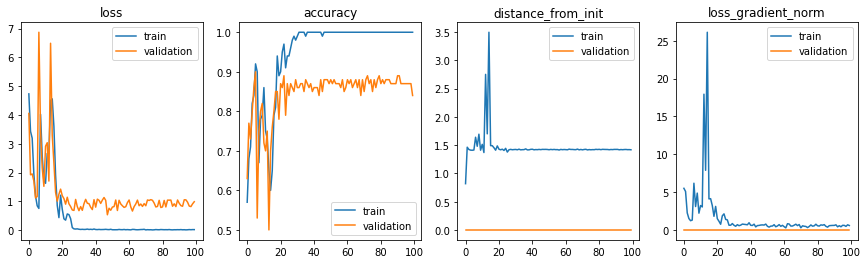

In [14]:
num_epochs = 100
model = SimpleNN(d, learning_rate=0.1,  hidden_layers=50, last_layer_activation=None, dist_from_init=1)
history = model.fit(x=X_train, y=Y_train, validation_data=(X_test,Y_test),
                            batch_size = 20, verbose=0, epochs=num_epochs)

visualize(history)

### Random Sketch

In [15]:
model.summary()

Model: "simple_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     multiple                  0         
                                                                 
 dense (Dense)               multiple                  500       
                                                                 
 dense_1 (Dense)             multiple                  50        
                                                                 
Total params: 1,100
Trainable params: 550
Non-trainable params: 550
_________________________________________________________________


In [16]:
W_trained = model.trainable_variables[0].numpy()
u_trained = model.trainable_variables[1].numpy()

In [17]:
# Verify parameters
np.concatenate([model.predict(X_test[:5, :]),
np.maximum(0, X_test[:5, :] @ W_trained) @ u_trained], axis=1)

1/1 [==============================] - 0s 54ms/step


array([[ 0.07279236,  0.07279229],
       [-2.25556302, -2.25556285],
       [ 1.5125432 ,  1.51254326],
       [ 0.5089184 ,  0.50891841],
       [-1.28323126, -1.28323132]])

In [18]:
%%time

k = 100
res_mean = np.zeros(k)
res_var = np.zeros(k)
real_res = model.predict(X_test)
for i in range(k):
    W_rs = random_sketch_matrix_single_column(W_trained, i+1, seed=i)
    rand_res = np.maximum(0, X_test @ W_rs) @ u_trained
    diff = real_res - rand_res
    res_mean[i] = np.mean(diff)
    res_var[i] = np.var(diff)

4/4 [==============================] - 0s 1000us/step
Wall time: 75.9 ms


Text(0.5, 1.0, 'variance')

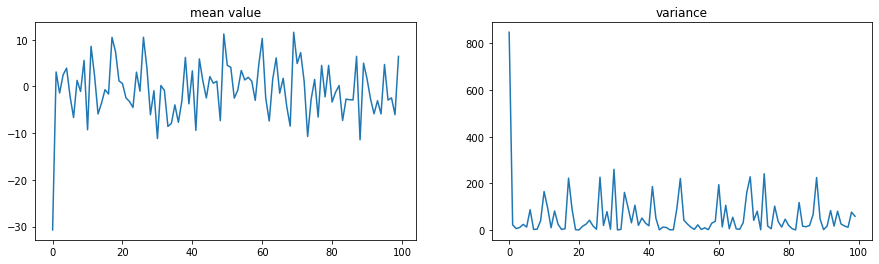

In [19]:
_, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].plot(res_mean)
axs[0].set_title('mean value')
axs[1].plot(res_var)
axs[1].set_title('variance')

4/4 [==============================] - 0s 2ms/step
Wall time: 434 ms


Text(0.5, 1.0, 'variance')

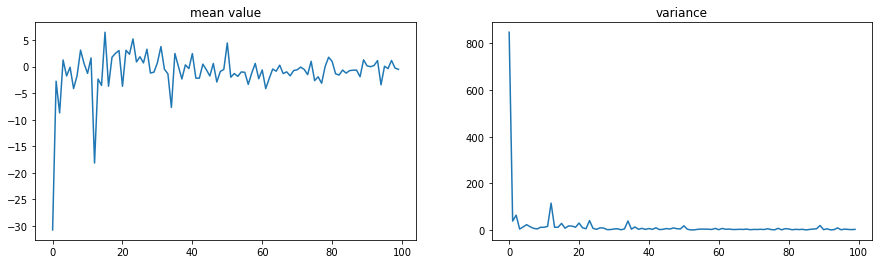

In [20]:
%%time

k = 100
res_mean = np.zeros(k)
res_var = np.zeros(k)
real_res = model.predict(X_test)
for i in range(k):
    W_rs = random_sketch_matrix_several_columns(W_trained, i+1, seed=i)
    rand_res = np.maximum(0, X_test @ W_rs) @ u_trained
    diff = real_res - rand_res
    res_mean[i] = np.mean(diff)
    res_var[i] = np.var(diff)
    
_, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].plot(res_mean)
axs[0].set_title('mean value')
axs[1].plot(res_var)
axs[1].set_title('variance')

### Dropout

In [21]:
num_epochs = 100
num_hidden = 100

(<Figure size 1080x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>,
        <AxesSubplot:title={'center':'distance_from_init'}>,
        <AxesSubplot:title={'center':'loss_gradient_norm'}>], dtype=object))

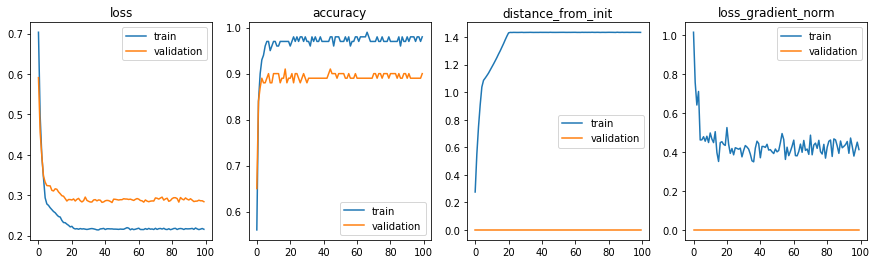

In [22]:
# Without Dropout
model = SimpleNN(d, learning_rate=0.1,  hidden_layers=num_hidden, dist_from_init=1)
history = model.fit(x=X_train, y=Y_train, validation_data=(X_test,Y_test),
                            batch_size = 20, verbose=0, epochs=num_epochs)

visualize(history)

0epoch [00:00, ?epoch/s]

(<Figure size 1080x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>,
        <AxesSubplot:title={'center':'distance_from_init'}>,
        <AxesSubplot:title={'center':'loss_gradient_norm'}>], dtype=object))

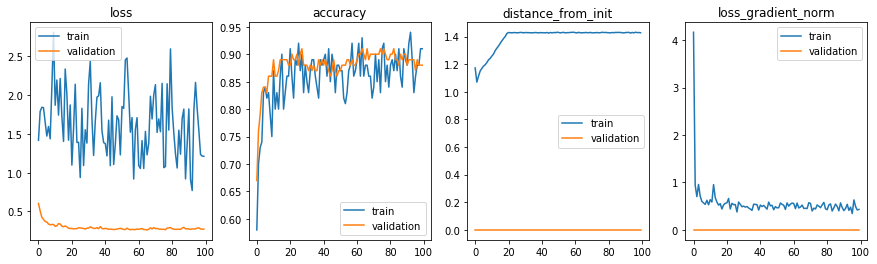

In [23]:
# With Dropout
dropout_rate = 0.2
model_do = SimpleNN(d, learning_rate=0.1,  hidden_layers=num_hidden,
                    dist_from_init=1, dropout_rate=dropout_rate)
history_do = model_do.fit(x=X_train, y=Y_train, validation_data=(X_test,Y_test),
                            batch_size = 20, verbose=0, epochs=num_epochs, callbacks=[TqdmCallback(verbose=0)])
visualize(history_do)

## ADL Dropout

Let $w\in\mathbb{R}^{n}$.
We want to randomly pick $\tilde{w}$ such that
$$
\tilde{w}_i =
\begin{cases}
\frac{w_i}{p_i}, & w.p. \; p_i=\frac{w_i^2}{\|w\|^2} \\
0, & otherwise
\end{cases}.
$$

Instead, we will use a bit different approach, for which $\tilde{w}_i = \frac{w_i}{p_i} \tilde{b}_i$ where $ \tilde{b}_i \sim Ber(p_i)$.
The difference is that we add an independence assumption between the elements.

Now, let $\hat{w}$ be an average of $k$ independence values of $\tilde{w}$.
That is, $\hat{w}_i = \frac{w_i}{p_i} \hat{b}_i$ where $\hat{b} \sim Bin(k, p_i)$.

It could be further approximated using normal distribution, but luckily, tensorflow knows how to distribute separately for each weight.

#### Debug ADL Dropout

In [24]:
def debug_adl(n, k, out_size=5):
    seed = 0
    inputs = tf.convert_to_tensor(X_test[:out_size, :n], dtype=tf.float32)

    w = tf.random.stateless_normal((n,n), (seed,seed), mean=0.0, stddev=1./np.sqrt(n))

    weights_sq = tf.math.square(w)
    norm_frobenious_sq = tf.math.reduce_sum(weights_sq)
    probs = weights_sq / norm_frobenious_sq
    mask = tf.random.stateless_binomial(shape=w.shape, seed=(seed+1, seed+1), counts=[k], probs=probs)

    normalized_weights = tf.math.divide(tf.cast(mask, dtype=w.dtype), w) * norm_frobenious_sq
    if k > 0:
        normalized_weights /= k
    res = tf.matmul(inputs, normalized_weights)
    
    return (w, inputs, res)

Text(0.5, 1.0, 'variance')

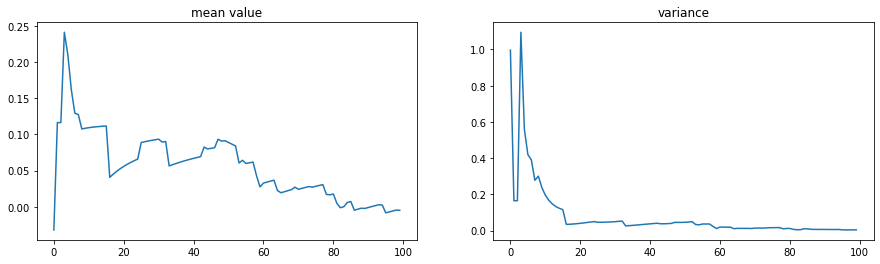

In [25]:
n = 2
k = 100
res_mean = np.zeros(k)
res_var = np.zeros(k)

real_w, inputs, _ = debug_adl(n, 0, out_size=5)
real_res = tf.matmul(inputs, real_w)

for i in range(k):
    _, _, rand_res = debug_adl(n, i, out_size=5)
    diff = (real_res - rand_res).numpy()
    res_mean[i] = np.mean(diff)
    res_var[i] = np.var(diff)
    
_, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].plot(res_mean)
axs[0].set_title('mean value')
axs[1].plot(res_var)
axs[1].set_title('variance')

In [26]:
k = 1000
seed = 0
inputs = tf.convert_to_tensor(X_train[:5, :n], dtype=tf.float32)
y_outputs = tf.convert_to_tensor(Y_train[:5], dtype=tf.float32)
w = tf.Variable(tf.random.stateless_normal([n,1], (seed,seed), mean=0.0, stddev=1./np.sqrt(n)))
weights_sq = tf.math.square(w)
norm_frobenious_sq = tf.math.reduce_sum(weights_sq)
probs = weights_sq / norm_frobenious_sq
mask = tf.random.stateless_binomial(shape=w.shape, seed=(seed+1, seed+1), counts=[k], probs=probs)

w, mask

(<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
 array([[-1.1999842 ],
        [-0.34038472]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[922],
        [ 73]])>)

In [27]:
with tf.GradientTape() as tape:    
    #with tape.stop_recording():
    if 1:
        weights_sq = tf.math.square(w)
        norm_frobenious_sq = tf.math.reduce_sum(weights_sq)
        probs = weights_sq / norm_frobenious_sq
    
    mask = tf.random.stateless_binomial(shape=w.shape, seed=(seed+1, seed+1), counts=[k], probs=probs)
    masked_weights = w * tf.cast(mask, dtype=w.dtype)
    
    normalized_weights = tf.math.divide(masked_weights, tf.stop_gradient(probs))
    if k > 0:
        normalized_weights /= k
    predictions = tf.matmul(inputs, normalized_weights)

    #loss = model.compiled_loss(y_outputs, predictions)
    loss = tf.reduce_sum(predictions) # TODO - should be removed and retutrn the previous line
    
# Compute gradients
[gradients] = tape.gradient(loss, [w])

# Update weights
#model.optimizer.apply_gradients(zip([gradients], [w]))

predictions, gradients

(<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 1.529074  ],
        [-1.529074  ],
        [-0.86174005],
        [ 0.86174005],
        [ 0.86174005]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-0.9961858],
        [ 0.9802643]], dtype=float32)>)

In [28]:
with tf.GradientTape() as tape:    
    with tape.stop_recording():
        weights_sq = tf.math.square(w)
        norm_frobenious_sq = tf.math.reduce_sum(weights_sq)
        probs = weights_sq / norm_frobenious_sq
    
    mask = tf.random.stateless_binomial(shape=w.shape, seed=(seed+1, seed+1), counts=[k], probs=probs)

    normalized_weights = tf.math.divide(tf.cast(mask, dtype=w.dtype), w) * norm_frobenious_sq
    if k > 0:
        normalized_weights /= k
    predictions = tf.matmul(inputs, normalized_weights)

    #loss = model.compiled_loss(y_outputs, predictions)
    loss = tf.reduce_sum(predictions) # TODO - should be removed and retutrn the previous line
    
# Compute gradients
[gradients] = tape.gradient(loss, [w])

# Update weights
#model.optimizer.apply_gradients(zip([gradients], [w]))

predictions, gradients

(<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 1.529074 ],
        [-1.529074 ],
        [-0.8617401],
        [ 0.8617401],
        [ 0.8617401]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 0.9961856 ],
        [-0.98026425]], dtype=float32)>)

In [29]:
# Compare to the regular case

with tf.GradientTape() as tape:
    predictions = tf.matmul(inputs, w)
    #loss = model.compiled_loss(y_outputs, predictions)
    loss = tf.reduce_sum(predictions) # TODO - should be removed and retutrn the previous line
    
[gradients] = tape.gradient(loss, [w])
#model.optimizer.apply_gradients(zip([gradients], [w]))

predictions, gradients

(<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 1.5403689],
        [-1.5403689],
        [-0.8595995],
        [ 0.8595995],
        [ 0.8595995]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-1.],
        [ 1.]], dtype=float32)>)

#### Model Implementation

In [30]:
class ADLDropout(base_layer.BaseRandomLayer):
    """Applies Dropout in ADL sense:
    This layer randomly sets input units to 0 with a frequency of `rate=1 - wi\R*k`
    at each step during training time, which helps prevent overfitting.
    Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over
    all inputs is unchanged.

    Note that the Dropout layer only applies when `training` is set to True.

    Args:
    rate: Float between 0 and 1. Fraction of the input units to drop.
    seed: A Python integer to use as random seed.
    Call arguments:
    inputs: Input tensor (of any rank).
    training: Python boolean indicating whether the layer should behave in
      training mode (adding dropout) or in inference mode (doing nothing).
    """

    def __init__(self, width,
                 k=1,
                 activation=None,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 seed=None,
                 max_radius=None,
                 from_init=False,
                 rate=None,
                 **kwargs):
        
        super(ADLDropout, self).__init__(seed=seed, **kwargs)
        
        self.width = width
        self.k = k
        self.seed = seed
        if seed is None:
            self.seed = np.random.randint(100)
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.max_radius = max_radius
        self.max_radius_sq = None
        self.from_init = from_init
        self.init_weights = None
        self.rate = rate

        
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.width),
            initializer=self.kernel_initializer, trainable=True)

        self.mask = self.add_weight(shape=(input_shape[-1], self.width),
            initializer="zero", trainable=False)
        
        self.init_weights = tf.Variable(self.w, trainable=False)
        self.init_weights.assign(self.w)
        
        if self.rate is not None:
            self.k = np.round(input_shape[-1] * self.width * self.rate)

    
    def call(self, inputs, training=None):
        res = None
        inputs = tf.cast(inputs, dtype=self.w.dtype)
        
        if training == True:
            if self.from_init == True:
                res = self.call_dropout_from_init(inputs)
            else:
                res = self.call_dropout_from_origin(inputs)
        else: # Not in training
            res = tf.matmul(inputs, self.w) # in case of bias add self.b
            
        if self.activation is not None:
            return self.activation(res)
        else:
            return res

        
    def call_dropout_from_origin(self, inputs):
        weights_sq = tf.math.square(self.w)
        if self.max_radius is None:
            self.max_radius_sq = tf.math.reduce_sum(weights_sq)
        else:
            self.max_radius_sq = self.max_radius * self.max_radius

        probs = tf.minimum(weights_sq / self.max_radius_sq, 1)
        self.mask = tf.cast(tf.random.stateless_binomial(shape=self.w.shape,
                                                         seed=(self.seed, self.seed+1),
                                                         counts=[self.k],
                                                         probs=probs), dtype=self.w.dtype)
        self.seed += 2

        masked_weights = self.w * tf.cast(self.mask, dtype=self.w.dtype)
        normalized_weights = tf.math.divide(masked_weights, tf.stop_gradient(probs))
        if self.k > 0:
            normalized_weights /= self.k
        return tf.matmul(inputs, normalized_weights)
    
    
    def call_dropout_from_init(self, inputs):
        weights_diff = self.w - self.init_weights
        weights_sq = tf.math.square(weights_diff)
        num_elements = tf.cast(tf.math.reduce_prod(self.w.shape), self.w.dtype)
        if self.max_radius is None:
            self.max_radius_sq = tf.math.reduce_sum(weights_sq)
        else:
            self.max_radius_sq = self.max_radius * self.max_radius

        probs = tf.ones(self.w.shape, dtype=self.w.dtype)
        if self.max_radius_sq > 0:
            probs = tf.minimum(weights_sq / self.max_radius_sq, 1) / 2 + 1 / num_elements / 2
        self.mask = tf.cast(tf.random.stateless_binomial(shape=self.w.shape,
                                                         seed=(self.seed, self.seed+1),
                                                         counts=[self.k],
                                                         probs=probs), dtype=self.w.dtype)
        self.seed += 2

        normalized_mask = tf.math.divide(tf.cast(self.mask, dtype=self.w.dtype), probs)
        if self.k > 0:
            normalized_mask /= self.k
        normalized_weights = self.w * tf.stop_gradient(normalized_mask) \
                             + tf.stop_gradient(self.init_weights * (1-normalized_mask))
        
        return tf.matmul(inputs, normalized_weights)
        #masked_weights = weights_diff * tf.cast(self.mask, dtype=self.w.dtype)
        #normalized_weights = tf.math.divide(masked_weights, tf.stop_gradient(probs))
        #if self.k > 0:
        #    normalized_weights /= self.k
        #return tf.matmul(inputs, normalized_weights + self.init_weights)

In [31]:
class ADLModel(SimpleNN):
    def __init__(self, input_dim, k=1, from_init=False, **kwargs):
        super(ADLModel, self).__init__(input_dim, **kwargs)
                    
        self.seq = Sequential()
        self.d1 = ADLDropout(self.hidden_layers,
                             input_dim=input_dim,
                             activation=keras.activations.relu,
                             max_radius=self.distance_from_init, k=k,
                             from_init=from_init,
                             kernel_initializer=RandomNormal(mean=0.0, stddev=1./np.sqrt(input_dim)))
        self.d2 = ADLDropout(1, activation=self.last_layer_activation,
                             max_radius=self.distance_from_init, k=k,
                             from_init=from_init,
                             kernel_initializer=RandomNormal(mean=0.0, stddev=1./np.sqrt(self.hidden_layers)))

        
    def call(self, x, training=None):
        x = self.seq(x)
        x = self.d1(x)
        return self.d2(x)

0epoch [00:00, ?epoch/s]

(<Figure size 1080x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>,
        <AxesSubplot:title={'center':'distance_from_init'}>,
        <AxesSubplot:title={'center':'loss_gradient_norm'}>], dtype=object))

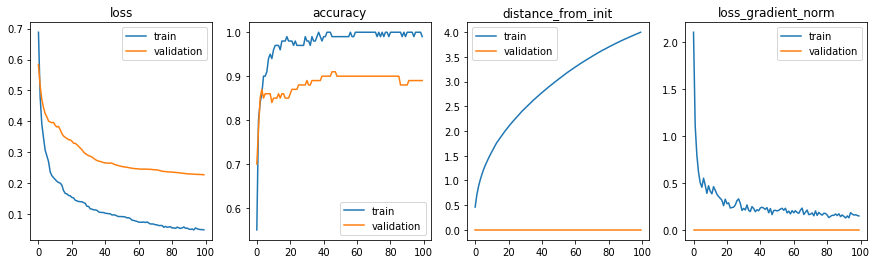

In [32]:
# With ADL Dropout
k = 1000
model_adl = ADLModel(d, learning_rate=0.1,  k=k, hidden_layers=num_hidden, seed=0)
history_adl = model_adl.fit(x=X_train, y=Y_train, validation_data=(X_test,Y_test),
                            batch_size = 20, verbose=0, epochs=num_epochs, callbacks=[TqdmCallback(verbose=0)])
visualize(history_adl)

0epoch [00:00, ?epoch/s]

(<Figure size 1080x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>,
        <AxesSubplot:title={'center':'distance_from_init'}>,
        <AxesSubplot:title={'center':'loss_gradient_norm'}>], dtype=object))

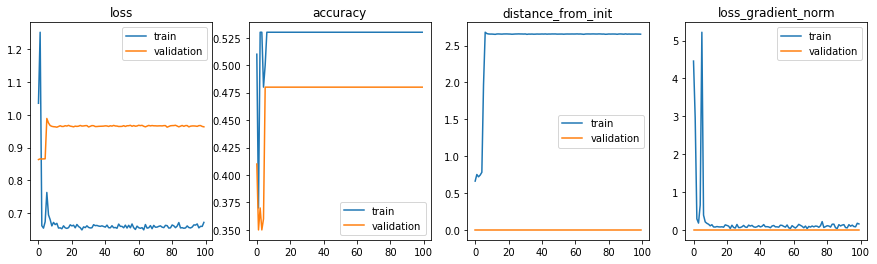

In [33]:
# With ADL Dropout
k = 50
model_adl = ADLModel(d, learning_rate=0.1,  k=k, hidden_layers=num_hidden, seed=0)
history_adl = model_adl.fit(x=X_train, y=Y_train, validation_data=(X_test,Y_test),
                            batch_size = 20, verbose=0, epochs=num_epochs, callbacks=[TqdmCallback(verbose=0)])
visualize(history_adl)

0epoch [00:00, ?epoch/s]

(<Figure size 1080x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>,
        <AxesSubplot:title={'center':'distance_from_init'}>,
        <AxesSubplot:title={'center':'loss_gradient_norm'}>], dtype=object))

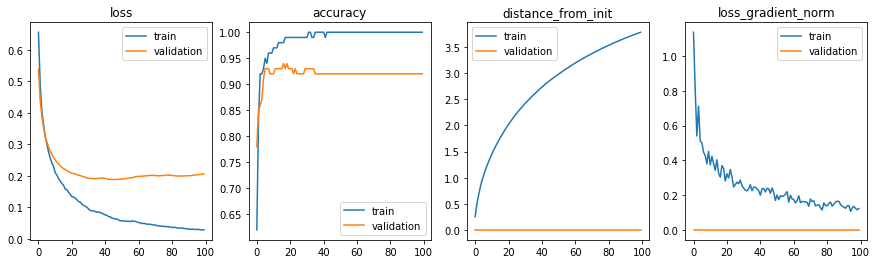

In [34]:
# With ADL Dropout From Init
k = 1000
model_adl = ADLModel(d, learning_rate=0.1,  k=k, hidden_layers=num_hidden, seed=0, from_init=True)
history_adl = model_adl.fit(x=X_train, y=Y_train, validation_data=(X_test,Y_test),
                            batch_size = 20, verbose=0, epochs=num_epochs, callbacks=[TqdmCallback(verbose=0)])
visualize(history_adl)

0epoch [00:00, ?epoch/s]

(<Figure size 1080x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>,
        <AxesSubplot:title={'center':'distance_from_init'}>,
        <AxesSubplot:title={'center':'loss_gradient_norm'}>], dtype=object))

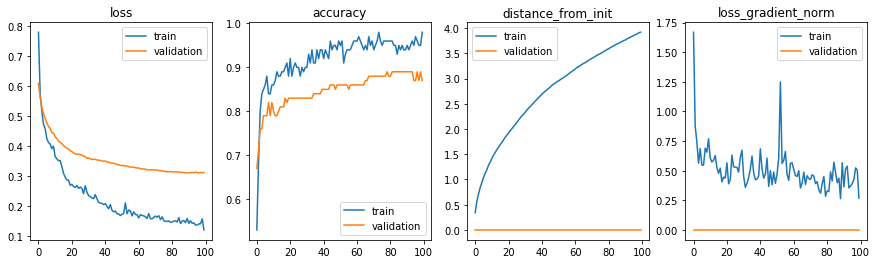

In [35]:
# With ADL Dropout From Init
k = 50
model_adl = ADLModel(d, learning_rate=0.1,  k=k, hidden_layers=num_hidden, seed=0, from_init=True)
history_adl = model_adl.fit(x=X_train, y=Y_train, validation_data=(X_test,Y_test),
                            batch_size = 20, verbose=0, epochs=num_epochs, callbacks=[TqdmCallback(verbose=0)])
visualize(history_adl)

## Performance Testing

In [36]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [37]:
dropout_rate = np.arange(0, 1, .1)
epochs = 15

In [51]:
# Simple Case

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(300, activation="relu", use_bias=False))
model.add(keras.layers.Dense(300, activation="relu", use_bias=False))
model.add(keras.layers.Dense(10, activation="softmax", use_bias=False))

optimizer = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=epochs,
          verbose=0, callbacks=[TqdmCallback(verbose=0)])
res_loss, res_acc = model.evaluate(X_test, y_test)

0epoch [00:00, ?epoch/s]

313/313 [==============================] - 1s 1ms/step - loss: 0.1641 - accuracy: 0.9691


In [38]:
# Regular Dropout

res_dropout = np.zeros((2,dropout_rate.size))

for i, r in tqdm(enumerate(dropout_rate)):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dropout(r))
    model.add(keras.layers.Dense(300, activation="relu", use_bias=False))
    model.add(keras.layers.Dropout(r))
    model.add(keras.layers.Dense(300, activation="relu", use_bias=False))
    model.add(keras.layers.Dropout(r))
    model.add(keras.layers.Dense(10, activation="softmax", use_bias=False))

    optimizer = keras.optimizers.Nadam(learning_rate=0.001)
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer, metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=epochs,
              verbose=0, callbacks=[TqdmCallback(verbose=0)])
    res_dropout[0,i], res_dropout[1,i] = model.evaluate(X_test, y_test)

0it [00:00, ?it/s]

0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 0.1749 - accuracy: 0.9708


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 0.1974 - accuracy: 0.9638


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 1s 1ms/step - loss: 0.1475 - accuracy: 0.9679


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 0.1682 - accuracy: 0.9614


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 1s 1ms/step - loss: 0.2031 - accuracy: 0.9498


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 0.3440 - accuracy: 0.9284


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 1.0214 - accuracy: 0.6422


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 1.8176 - accuracy: 0.2921


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 1s 1ms/step - loss: 2.3007 - accuracy: 0.0992


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 1s 1ms/step - loss: 2.3026 - accuracy: 0.0980


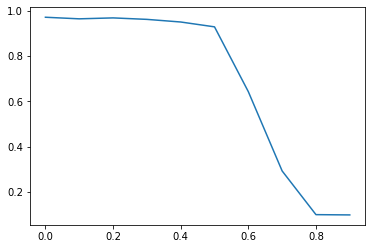

In [39]:
plt.plot(dropout_rate, res_dropout[1,:])

In [74]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(ADLDropout(300, activation=keras.activations.relu, rate=r, from_init=False))
model.add(ADLDropout(300, activation=keras.activations.relu, rate=r, from_init=False))
model.add(ADLDropout(10, activation=keras.activations.softmax, rate=r, from_init=False))

optimizer = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10,
          verbose=0, callbacks=[TqdmCallback(verbose=0)])
model.evaluate(X_test, y_test)

0epoch [00:00, ?epoch/s]

313/313 [==============================] - 1s 2ms/step - loss: 14.1461 - accuracy: 0.4778


[14.146060943603516, 0.47780001163482666]

In [78]:
model.evaluate(X_train, y_train)

1875/1875 [==============================] - 3s 2ms/step - loss: 13.3337 - accuracy: 0.4906


[13.333688735961914, 0.4906333386898041]

In [93]:
model.layers[1].from_init

False

In [92]:
tf.reduce_mean(keras.losses.sparse_categorical_crossentropy(y_train, model(X_train, training=True)))

<tf.Tensor: shape=(), dtype=float32, numpy=121.05838>

In [40]:
res_dropout_adl = np.zeros((2,len(dropout_rate)))

for i, r in tqdm(enumerate(dropout_rate)):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(ADLDropout(300, activation=keras.activations.relu, rate=r, from_init=False))
    model.add(ADLDropout(300, activation=keras.activations.relu, rate=r, from_init=False))
    model.add(ADLDropout(10, activation=keras.activations.softmax, rate=r, from_init=False))

    optimizer = keras.optimizers.Nadam(learning_rate=0.001)
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer, metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=epochs,
              verbose=0, callbacks=[TqdmCallback(verbose=0)])
    res_dropout_adl[0,i], res_dropout_adl[1,i] = model.evaluate(X_test, y_test)

0it [00:00, ?it/s]

0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 92.4129 - accuracy: 0.1055


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 95.9218 - accuracy: 0.1182


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 49.4870 - accuracy: 0.1192


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 43.1103 - accuracy: 0.2090


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 40.4332 - accuracy: 0.2157


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 31.4537 - accuracy: 0.3192


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 37.0912 - accuracy: 0.3402


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 36.9473 - accuracy: 0.3610


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 40.5358 - accuracy: 0.2458


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 1s 1ms/step - loss: 9.1778 - accuracy: 0.5968


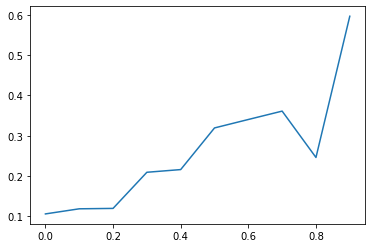

In [42]:
plt.plot(dropout_rate, res_dropout_adl[1,:])

In [43]:
res_dropout_adl_diff = np.zeros((2,len(dropout_rate)))

for i, r in tqdm(enumerate(dropout_rate)):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(ADLDropout(300, activation=keras.activations.relu, rate=r, from_init=True))
    model.add(ADLDropout(300, activation=keras.activations.relu, rate=r, from_init=True))
    model.add(ADLDropout(10, activation=keras.activations.softmax, rate=r, from_init=True))

    optimizer = keras.optimizers.Nadam(learning_rate=0.001)
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer, metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=epochs,
              verbose=0, callbacks=[TqdmCallback(verbose=0)])
    res_dropout_adl_diff[0,i], res_dropout_adl_diff[1,i] = model.evaluate(X_test, y_test)

0it [00:00, ?it/s]

0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 91.4224 - accuracy: 0.1001


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 9.6441 - accuracy: 0.7651


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 6.3604 - accuracy: 0.8146


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 2.4623 - accuracy: 0.9062


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 2.1280 - accuracy: 0.9251


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 1.2914 - accuracy: 0.9312


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 2.0986 - accuracy: 0.9073


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 1.7920 - accuracy: 0.9091


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 1s 1ms/step - loss: 0.8624 - accuracy: 0.9418


0epoch [00:00, ?epoch/s]

313/313 [==============================] - 0s 1ms/step - loss: 1.1369 - accuracy: 0.9008


Text(0, 0.5, 'accuracy')

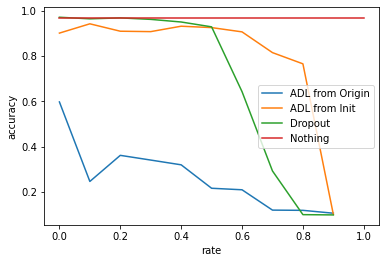

In [52]:
plt.plot(dropout_rate, res_dropout_adl[1,::-1], dropout_rate,
         res_dropout_adl_diff[1,::-1],dropout_rate, res_dropout[1,:],
        [0,1],[res_acc, res_acc])
plt.legend(['ADL from Origin','ADL from Init', 'Dropout','Nothing'])
plt.xlabel('rate')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

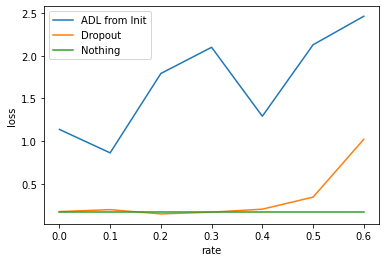

In [73]:
plt.plot(#dropout_rate[:7], res_dropout_adl[0,:2:-1],
         dropout_rate[:7], res_dropout_adl_diff[0,:2:-1],
         dropout_rate[:7], res_dropout[0,:7],
        [0,.6],[res_loss, res_loss])
plt.legend(['ADL from Init', 'Dropout','Nothing'])
plt.xlabel('rate')
plt.ylabel('loss')

### Comparing to Original Paper

The paper is called "Dropout:  A Simple Way to Prevent Neural Networks fromOverfitting" and can be found [here](moz-extension://cb5ce5cd-fad9-42cf-b14d-a6c3819355df/enhanced-reader.html?openApp&pdf=https%3A%2F%2Fjmlr.org%2Fpapers%2Fvolume15%2Fsrivastava14a%2Fsrivastava14a.pdf).
Code is [here](http://www.cs.toronto.edu/~nitish/dropout/).

In [59]:
# Original Model

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(800, activation="relu", use_bias=False))
model.add(keras.layers.Dense(800, activation="relu", use_bias=False))
model.add(keras.layers.Dense(10, activation="softmax", use_bias=False))

optimizer = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=epochs,
          verbose=0, callbacks=[TqdmCallback(verbose=0)])
model.evaluate(X_test, y_test)

0epoch [00:00, ?epoch/s]

313/313 [==============================] - 1s 3ms/step - loss: 0.2123 - accuracy: 0.9667


[0.21230731904506683, 0.96670001745224]

In [60]:
# Dropout Model

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(800, activation="relu", use_bias=False))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(800, activation="relu", use_bias=False))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation="softmax", use_bias=False))

optimizer = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=epochs,
          verbose=0, callbacks=[TqdmCallback(verbose=0)])
model.evaluate(X_test, y_test)

0epoch [00:00, ?epoch/s]

313/313 [==============================] - 1s 3ms/step - loss: 0.1915 - accuracy: 0.9584


[0.19151417911052704, 0.9584000110626221]

In [ ]:
# w.o. dropout [0.18247081339359283, 0.9718999862670898]
# w. dropout [0.36893904209136963, 0.896399974822998]